In [26]:
# Imported library for current project

import numpy as np

import pandas as pd

from pathlib import Path

import matplotlib.pyplot as plt

%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* CAD/JPY exchange rate returns. 

In [27]:
# Currency pair exchange rates for CAD/JPY

cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)

cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [28]:
# Trimmed the dataset to begin on January 1st, 1990

cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]

cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


In [29]:
# Checked info of Pandas Dataframe

cad_jpy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7929 entries, 1990-01-02 to 2020-06-04
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   7929 non-null   float64
 1   Open    7929 non-null   float64
 2   High    7929 non-null   float64
 3   Low     7929 non-null   float64
dtypes: float64(4)
memory usage: 309.7 KB


# Data Preparation

### Returns

In [30]:
# Created a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s

returns_df = (cad_jpy_df[['Price']].pct_change() * 100)

returns_df = returns_df.replace(-np.inf, np.nan).dropna()

cad_jpy_df['Return'] = returns_df.copy()

cad_jpy_df.tail()

,Price,Open,High,Low,Return
Date,,,,,
2020-05-29,78.29,78.21,78.41,77.75,0.076697
2020-06-01,79.27,78.21,79.36,78.04,1.251756
2020-06-02,80.40,79.26,80.56,79.15,1.425508
2020-06-03,80.70,80.40,80.82,79.96,0.373134
2020-06-04,80.71,80.80,80.89,80.51,0.012392


### Lagged Returns 

In [31]:
# Created a lagged return using the shift function

cad_jpy_df['Lagged_Return'] = returns_df.shift()

cad_jpy_df = cad_jpy_df.dropna()

cad_jpy_df.tail()

,Price,Open,High,Low,Return,Lagged_Return
Date,,,,,,
2020-05-29,78.29,78.21,78.41,77.75,0.076697,-0.114913
2020-06-01,79.27,78.21,79.36,78.04,1.251756,0.076697
2020-06-02,80.40,79.26,80.56,79.15,1.425508,1.251756
2020-06-03,80.70,80.40,80.82,79.96,0.373134,1.425508
2020-06-04,80.71,80.80,80.89,80.51,0.012392,0.373134


### Train Test Split

In [32]:
# Created a train/test split for the data using 2018-2019 for testing and the rest for training

train = cad_jpy_df[:'2017']

test = cad_jpy_df['2018':]

In [33]:
# Initialized train dataframe

train.head()

,Price,Open,High,Low,Return,Lagged_Return
Date,,,,,,
1990-01-04,123.46,123.41,123.46,123.41,-1.468476,-0.846720
1990-01-05,124.54,124.48,124.54,124.48,0.874777,-1.468476
1990-01-08,124.27,124.21,124.27,124.21,-0.216798,0.874777
1990-01-09,125.10,125.04,125.10,125.04,0.667901,-0.216798
1990-01-10,125.81,125.75,125.81,125.75,0.567546,0.667901


In [34]:
# Created four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):

train.dropna(inplace=True)

test.dropna(inplace = True)

# Created four dataframes for train and test

x_train  = train['Lagged_Return'].to_frame()

x_test = test['Lagged_Return'].to_frame()

y_train = train['Return']

y_test = test['Return']

<ipython-input-34-69171f3694d0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace=True)
<ipython-input-34-69171f3694d0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.dropna(inplace = True)


In [35]:
# Initialized the X_train data

x_train

,Lagged_Return
Date,
1990-01-04,-0.846720
1990-01-05,-1.468476
1990-01-08,0.874777
1990-01-09,-0.216798
1990-01-10,0.667901
...,...
2017-12-25,-0.011240
2017-12-26,0.033723
2017-12-27,0.269693


# Linear Regression Model

In [36]:
# Created a Linear Regression model and fit it to the training data

from sklearn.linear_model import LinearRegression

# Fitted a SKLearn linear regression using  just the training set (X_train, Y_train):

model = LinearRegression()

model.fit(x_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

**Note:** We want to evaluate the model using data that it has never seen before, in this case: `X_test`.

In [37]:
# Made a prediction of "y" values using just the test dataset

predictions_y = model.predict(x_test)


In [38]:
# Assembled actual y data (y_test) with predicted y data into two columns in a dataframe:

sample_results_y = y_test.to_frame()

sample_results_y["Predicted Return"] = predictions_y


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000226CFD52100>,
      dtype=object)

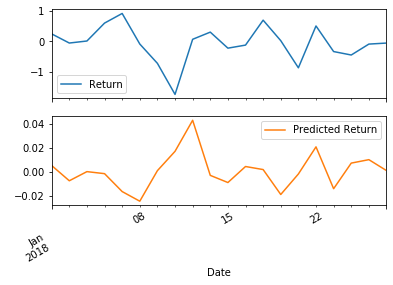

In [42]:
# Plotted the first 20 predictions vs the true values

sample_results_y[:20].plot(subplots=True)


# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (`X_test` and `y_test`)

In [44]:
from sklearn.metrics import mean_squared_error


# Calculated the mean_squared_error (MSE) on actual versus predicted test "y" 

mse = mean_squared_error(
    sample_results_y["Return"],
    sample_results_y["Predicted Return"]
)


# Used the mean-squared-error and calculated the root-mean-squared error (RMSE):
out_sample_rmse = np.sqrt(mse)

print(f"Out-of-Sample Root Mean Squared Error (RMSE): {out_sample_rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.6445805658569028


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [45]:
# Constructd a dataframe using just the "y" training data:

in_sample_results = y_train.to_frame()

# Added a column of "in-sample" predictions to that dataframe:  

in_sample_results["In-sample Predictions"] = model.predict(x_train)

# Calculated in-sample mean_squared_error (for comparison to out-of-sample)

in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)

# Calculated in-sample root mean_squared_error (for comparison to out-of-sample)

in_sample_rmse = np.sqrt(in_sample_mse)

print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.841994632894117


# Conclusions

**Question:**

 Does this model perform better or worse on out-of-sample data as compared to in-sample data?

**Answer:** 

Results: 

Out-of-Sample Root Mean Squared Error (RMSE): 0.6445805658569028

In-sample Root Mean Squared Error (RMSE): 0.841994632894117

Based on the results. The model performs better on the out-of-sample data compared to the in-sample data. Perfomance is better if you have a low RMSE. In this case, out-of-sample data has a lower RMSE as compared to the in-sample data. 